In [40]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.sparse.linalg as spLA
import scipy
from scipy import sparse as sp
from scipy.sparse import coo_matrix,spdiags,csr_matrix

import sys
sys.path.insert(1, '../')

import SpringRank_tools as sr
import tools as tl

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Inferring ranks and group preferences


$$ H^{++} = H(s, \theta) + \tfrac{1}{2} \lambda_s ||s||_2^2 + \tfrac{1}{2} \lambda_{\theta} ||\theta||_2^2 $$

Want to solve:
$$\begin{align}
\nabla H^{++} &= 0 \\
\implies \nabla_s : \nabla_s H + \lambda_s s &= 0, \\
\nabla_{\theta} : \nabla_{\theta} H + \lambda_{\theta} \theta &= 0
\end{align}$$

Define:
$$\begin{align}
\Lambda_s &= \lambda_s I_{N} \\
\Lambda_{\theta} &= \lambda_{\theta} I_{k}
\end{align}$$

So, solve:
$$
\begin{bmatrix}
L + \Lambda_s & LG \\
G^T L & G^T LG + \Lambda_{\theta}
\end{bmatrix} \begin{bmatrix}
s \\
\theta \\
\end{bmatrix} = \begin{bmatrix}
\hat{d} \\
G^{T} \hat{d}
\end{bmatrix}
$$

In [193]:
# # Custom planting

# n = 200
# N = n*3
# dist1 = (-4, 2)
# dist2 = (1, 0.5)
# dist3 = (4, 1)

# beta = 4
# p_ij = 1 / (1 + np.exp(-2*beta))
# K = 10

# scores = {}
# scores["individual"] = np.concatenate((np.random.normal(dist1[0], dist1[1], n),
#                                        np.random.normal(dist2[0], dist2[1], n),
#                                        np.random.normal(dist3[0], dist3[1], n)), axis=0)

# k = 4
# distk = (0, 1)
# groups = np.random.randint(0, k, N)
# G = np.zeros((N, k))
# for j, g_j in enumerate(groups):
#     G[j, g_j] = 1
# scores["cat_01"] = np.random.normal(distk[0], distk[1], k)

# ranks = scores["individual"] + np.matmul(G, scores["cat_01"])

# scaled_exp_energy = np.zeros((N, N))
# Z = 0
# for i in range(N):
#     for j in range(N):
#         energy_ij = 0.5 * np.power(ranks[i]-ranks[j]-1, 2)
#         scaled_exp_energy[i, j] = np.exp(-beta * energy_ij)
#         Z += scaled_exp_energy[i, j]
# c = float(K * N) / Z

# # Build network
# A = np.zeros((N, N))

# for i in range(N):
#     for j in range(N):
#         if i == j:
#             continue

#         lambda_ij = c * scaled_exp_energy[i, j]
#         A_ij = np.random.poisson(lambda_ij)
#         if A_ij > 0:
#             A[i, j] = A_ij

# G = {"cat_01": G}

In [2]:
N = 500
num_groups = {
              "cat_01" : 4,
#               "cat_02": 5
             }
l0 = {
      "individual": 0.5,
      "cat_01": 2,
#       "cat_02": 1
     }
alpha = {
         "individual": 1,
         "cat_01": 1,
#          "cat_02": 1
        }
beta = 0.1
p_ij = 1 / (1 + np.exp(-2*beta))
K = 10

A, G, scores, ranks = sr.SpringRank_planted_network_groups(
                            N, num_groups, beta, alpha, K, np.random, l0, l1=1,
                            allow_self_loops=False, return_ranks=True)

A = np.array(nx.to_numpy_matrix(A))

0.5 3.162277660168379
2 3.162277660168379


In [4]:
reg_coeff = {
             "individual": 1e-1,
             "cat_01": 1e-1,
#              "cat_02": 1e-1
            }

ranks_est, scores_est = sr.SpringRank_groups(A, G, reg_coeff, solver='bicgstab')

scaled_ranks = tl.adjust_ranks(ranks_est, A, p_ij=p_ij)

temperature = tl.get_temperature(scores_est["individual"], A, p_ij, interval=(0.01, 20))
scores_est_scaled = tl.shift_ranks(temperature*scores_est["individual"])

In [205]:
cat = "cat_01"

groups = np.where(G[cat]==1)[1]
theta = scores[cat]
theta_est = scores_est[cat]

print("    s mean: ", np.mean(scores_est["individual"]))
print("theta mean: ", np.mean(theta_est))

    s mean:  -4.1744385725905886e-17
theta mean:  -4.5054238118069634e-14


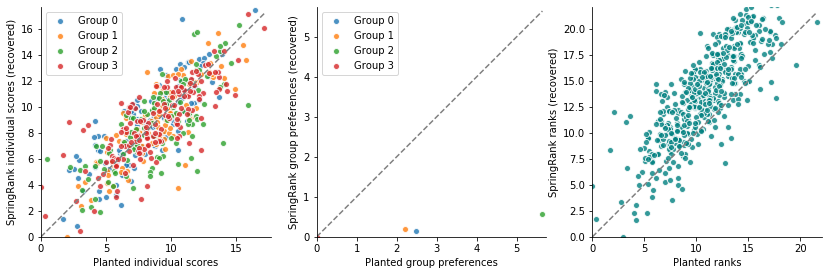

In [207]:
alpha = 0.5

shifted_scores = tl.shift_ranks(scores["individual"])
shifted_ranks = tl.shift_ranks(ranks)
theta_shifted = theta - np.min(theta)

fig,ax = plt.subplots(1,3,figsize=(2*7,7))

for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

ax[0].plot(np.linspace(np.min(shifted_scores), np.max(shifted_scores), 10),
           np.linspace(np.min(shifted_scores), np.max(shifted_scores), 10),
           color='gray', linestyle='dashed')
for i in range(np.max(groups)+1):
    ax[0].scatter(shifted_scores[groups==i],
                  scores_est_scaled[groups==i],
                  marker='o', alpha=0.8, edgecolor='white',
                  label="Group {}".format(i))

ax[0].axis('square')
ax[0].set_xlabel("Planted individual scores")
ax[0].set_ylabel("SpringRank individual scores (recovered)")
ax[0].set_xlim(np.min(shifted_scores), np.max(shifted_scores)+0.5)
ax[0].set_ylim(np.min(shifted_scores), np.max(shifted_scores)+0.5)
ax[0].legend()

ax[1].plot(np.linspace(np.min(theta_shifted), np.max(theta_shifted), 10),
           np.linspace(np.min(theta_shifted), np.max(theta_shifted), 10),
           color='gray', linestyle='dashed')
for i in range(np.max(groups)+1):
    ax[1].scatter(theta_shifted[i],
                  (theta_est[i] - np.min(theta_est)),
                  marker='o',
                  edgecolor='white',
                  alpha=0.8,
                  label="Group {}".format(i))
ax[1].axis('square')
ax[1].set_xlabel("Planted group preferences")
ax[1].set_ylabel("SpringRank group preferences (recovered)")
ax[1].set_xlim(np.min(theta_shifted), np.max(theta_shifted)+0.1)
ax[1].set_ylim(np.min(theta_shifted), np.max(theta_shifted)+0.1)
ax[1].legend()


ax[2].plot(np.linspace(np.min(shifted_ranks), np.max(shifted_ranks), 10),
           np.linspace(np.min(shifted_ranks), np.max(shifted_ranks), 10),
           color='gray', linestyle='dashed')
ax[2].scatter(shifted_ranks,
              scaled_ranks,
              color='teal', edgecolor='white', alpha=0.8)
ax[2].axis('square')
ax[2].set_xlabel("Planted ranks")
ax[2].set_ylabel("SpringRank ranks (recovered)")
ax[2].set_xlim(np.min(shifted_ranks), np.max(shifted_ranks)+0.5)
ax[2].set_ylim(np.min(shifted_ranks), np.max(shifted_ranks)+0.5)


plt.savefig("../../figures/GroupsTest1-beta0.1.PNG", dpi=200)

plt.show()